In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
customers = pd.read_csv("Ecommerce/olist_customers_dataset.csv")
order_items = pd.read_csv("Ecommerce/olist_order_items_dataset.csv")
orders = pd.read_csv("Ecommerce/olist_orders_dataset.csv")
products = pd.read_csv("Ecommerce/olist_products_dataset.csv")

reviews = pd.read_csv("Ecommerce/olist_order_reviews_dataset.csv")
reviews = reviews[['review_id', 'order_id', 'review_score']]

category_map = pd.read_csv("Ecommerce/product_category_name_translation.csv")

# 카테고리 이름 영어로
products = products.merge(category_map, on="product_category_name", how="left")
products = products.drop(columns=['product_category_name'])
products = products.rename(columns={'product_category_name_english': 'product_category'})
products = products[['product_id','product_category', 'product_description_lenght',	'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']]


customers['customer_state'].value_counts().count() # 27
display(customers.head())
display(order_items.head())
display(orders.head())

customers.agg({
    'customer_id':'nunique',
    'customer_unique_id':'nunique'
})

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


customer_id           99441
customer_unique_id    96096
dtype: int64

In [ ]:
# 주문별 금액 구하기
order_total = order_items.groupby('order_id')['price'].sum().reset_index()
order_total.rename(columns={'price':'total_price'}, inplace=True)

# 주문별 금액을 orders에 추가
orders = orders.merge(order_total, on='order_id', how='left')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,total_price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90


In [4]:
# 주문 고객 df
orders_customers = orders.merge(customers[['customer_id', 'customer_unique_id', 'customer_state', 'customer_zip_code_prefix', 'customer_city']], on='customer_id', how='left')
display(orders_customers.head())

# 주문 항목 df
orders_items = orders.merge(order_items, on='order_id', how='left')
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,total_price,customer_unique_id,customer_state,customer_zip_code_prefix,customer_city
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99,7c396fd4830fd04220f754e42b4e5bff,SP,3149,sao paulo
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70,af07308b275d755c9edb36a90c618231,BA,47813,barreiras
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90,3a653a41f6f9fc3d2a113cf8398680e8,GO,75265,vianopolis
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00,7c142cf63193a1473d2e66489a9ae977,RN,59296,sao goncalo do amarante
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90,72632f0f9dd73dfee390c9b22eb56dd6,SP,9195,santo andre


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,total_price,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [16]:
# 기준 날짜 설정  Timestamp('2018-10-17 17:30:18')
# datetime 변환
orders_customers['order_purchase_timestamp'] = pd.to_datetime(orders_customers['order_purchase_timestamp'])


# RFM 계산
date = pd.to_datetime('2018-10-17')

rfm = orders_customers.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x:(date-x.max()).days,
    'order_id': 'nunique',
    'total_price': 'sum'

}).reset_index()

rfm.rename(columns={
    'order_purchase_timestamp': 'recency',
    'order_id': 'frequency',
    'total_price': 'monetary'
}, inplace=True)

# RFM 점수 부여 (가중치)
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# 그냥 계산하니까 SP가 vvip젤 많다고 나오는데.. 사실 구매 금액은 가장 적은 문제.. 그래서 m에 가중치 더 줌
rfm['rfm_score'] = (rfm['r_score']*0.3 + rfm['f_score']*0.3 + rfm['m_score']*0.4)


# 고객 세그먼트 나누기
def segment_customer(score):
    '''
    score>=4.5 VVIP
    score>=3.8 단골
    score>=3.0 잠재고객
    score>=2.0 위험
    그외 휴면
    '''
    if score >= 4.5:
        return 'VVIP'
    elif score >= 3.8:
        return 'Regular'
    elif score >= 3.0:
        return 'Potential'
    elif score >= 2.0:
        return 'Risk'
    else:
        return 'Dormant'

rfm['segment'] = rfm['rfm_score'].apply(segment_customer)
display(rfm.head())




# 지역별 구하려고 rfm이랑 병합
rfm = rfm.merge(customers[['customer_unique_id', 'customer_state']], on='customer_unique_id', how='left')

# 주 별로 세그먼트
state_segment = rfm.groupby(['customer_state', 'segment']).size().unstack()

# 주별 평균 rfm
state_rfm = rfm.groupby('customer_state')[['recency', 'frequency', 'monetary']].mean()
state_rfm.sort_values(['monetary', 'recency'], ascending=[False, True])

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,159,1,129.90,4,1,4,3.1,Potential
1,0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,18.90,4,1,1,1.9,Dormant
2,0000f46a3911fa3c0805444483337064,585,1,69.00,1,1,2,1.4,Dormant
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,25.99,2,1,1,1.3,Dormant
4,0004aac84e0df4da2b147fca70cf8255,336,1,180.00,2,1,5,2.9,Risk


,recency,frequency,monetary
customer_state,,,
PB,292.470149,1.089552,228.134496
AC,355.493827,1.098765,215.063086
AL,314.883777,1.060533,209.232276
AP,296.911765,1.029412,205.058824
RO,323.067194,1.138340,196.869407
PA,312.582564,1.057436,189.799641
PI,298.686869,1.060606,184.657717
TO,298.364286,1.050000,183.934286
RR,319.934783,1.043478,183.159348


In [ ]:
# 주별 세그먼트 정렬..
state_segment = rfm.groupby(['customer_state', 'segment']).size().unstack()
state_segment = state_segment.sort_values('VVIP', ascending=False)

# 주별로 세그먼트 퍼센트 구하기
state_segment_pct = (state_segment / state_segment.values.sum() * 100).round(2)
state_segment_pct = state_segment_pct[['VVIP', 'Regular', 'Potential', 'Risk', 'Dormant']]
state_segment_pct.head()


segment,VVIP,Regular,Potential,Risk,Dormant
customer_state,,,,,
SP,1.86,7.17,12.93,15.18,4.84
RJ,0.59,2.38,4.01,4.51,1.43
MG,0.53,2.03,3.76,4.04,1.34
PR,0.25,0.86,1.55,1.79,0.64
RS,0.22,0.99,1.66,1.99,0.64


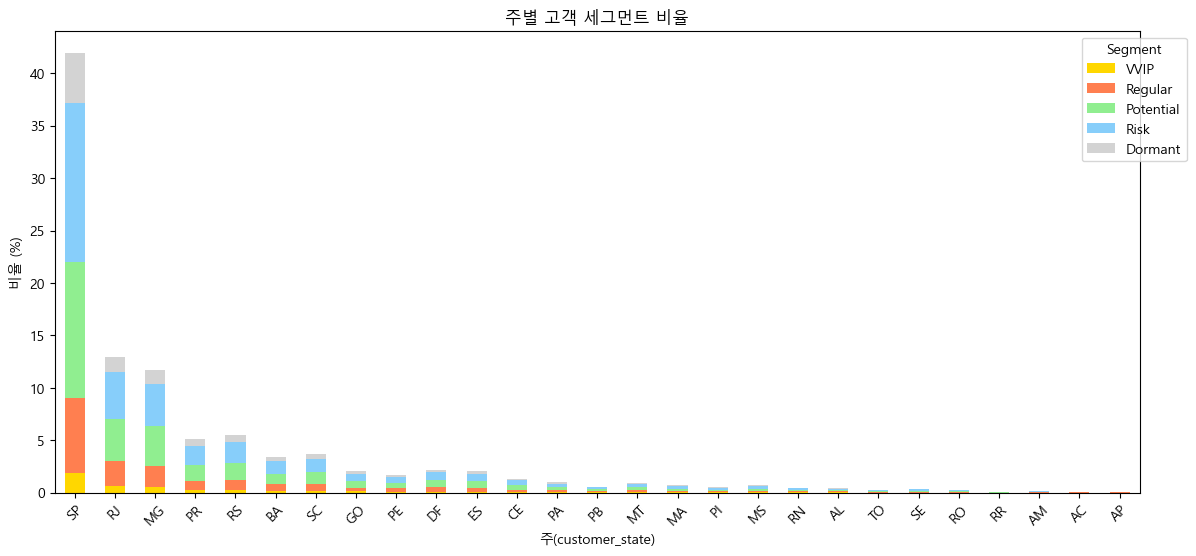

In [7]:
import matplotlib.pyplot as plt

state_segment_pct = state_segment_pct[['VVIP', 'Regular', 'Potential', 'Risk', 'Dormant']]

# 색상 지정 (원하는 색으로)
colors = ['#FFD700',  # VVIP - 금색
          '#FF7F50',  # Regular - 주황
          '#90EE90',  # Potential - 연초록
          '#87CEFA',  # Risk - 하늘
          '#D3D3D3']  # Dormant - 회색

# 시각화
state_segment_pct.plot(kind='bar', stacked=True, figsize=(14,6), color=colors)
plt.title('주별 고객 세그먼트 비율')
plt.ylabel('비율 (%)')
plt.xlabel('주(customer_state)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.show()

In [8]:
'''
1. VVIP / Regular 중심 지역 (대형 주: SP, RJ, MG 등)
목표: 충성 고객 유지 & 매출 극대화

VVIP
프리미엄 쿠폰 제공
신상품/한정상품 우선 제공
VIP 전용 이벤트/체험 기회 제공

Regular
업셀링 & 크로스셀링 캠페인
관련 상품 묶음 할인 제안
구매 빈도 향상을 위한 맞춤형 추천

추가 포인트:
VIP 등급별 전용 커뮤니케이션 채널(앱 푸시, SMS 등) 활용
구매 패턴 분석 후 개인화 제안 강화


2. Potential 고객 중심 지역
목표: 재구매 촉진 & 구매 전환 확대

재구매 촉진
이메일 / 앱 알림 통한 재구매 유도
재구매 쿠폰 제공 (기간 한정)
상품 추천
구매 데이터 기반 맞춤 추천
관련 상품 묶음 또는 세트 제안

추가 포인트:
추천 시스템 정확도 향상을 위해 최근 구매, 장바구니, 탐색 기록 활용
알림 메시지에 개인화 요소 포함 (이름, 최근 구매 상품 등)


3. Dormant / Risk 비중 높은 지역 (작은 주, 외곽 지역)
목표: 저비용으로 휴면 고객 회수 & 관리 최소화

Win-back 캠페인
뉴스레터, 할인 쿠폰 등 저비용 마케팅
장기 미구매 고객 대상 간헐적 리마인드

고객 관리 최소화
장기간 미구매 고객은 과도한 마케팅 자원 투입 자제
ROI 대비 효과가 낮은 채널 최소화

추가 포인트:
회수 성공률이 높은 고객 그룹 중심으로 집중
데이터 기반으로 마케팅 비용 효율화
'''

'\n1. VVIP / Regular 중심 지역 (대형 주: SP, RJ, MG 등)\n목표: 충성 고객 유지 & 매출 극대화\n\nVVIP\n프리미엄 쿠폰 제공\n신상품/한정상품 우선 제공\nVIP 전용 이벤트/체험 기회 제공\n\nRegular\n업셀링 & 크로스셀링 캠페인\n관련 상품 묶음 할인 제안\n구매 빈도 향상을 위한 맞춤형 추천\n\n추가 포인트:\nVIP 등급별 전용 커뮤니케이션 채널(앱 푸시, SMS 등) 활용\n구매 패턴 분석 후 개인화 제안 강화\n\n\n2. Potential 고객 중심 지역\n목표: 재구매 촉진 & 구매 전환 확대\n\n재구매 촉진\n이메일 / 앱 알림 통한 재구매 유도\n재구매 쿠폰 제공 (기간 한정)\n상품 추천\n구매 데이터 기반 맞춤 추천\n관련 상품 묶음 또는 세트 제안\n\n추가 포인트:\n추천 시스템 정확도 향상을 위해 최근 구매, 장바구니, 탐색 기록 활용\n알림 메시지에 개인화 요소 포함 (이름, 최근 구매 상품 등)\n\n\n3. Dormant / Risk 비중 높은 지역 (작은 주, 외곽 지역)\n목표: 저비용으로 휴면 고객 회수 & 관리 최소화\n\nWin-back 캠페인\n뉴스레터, 할인 쿠폰 등 저비용 마케팅\n장기 미구매 고객 대상 간헐적 리마인드\n\n고객 관리 최소화\n장기간 미구매 고객은 과도한 마케팅 자원 투입 자제\nROI 대비 효과가 낮은 채널 최소화\n\n추가 포인트:\n회수 성공률이 높은 고객 그룹 중심으로 집중\n데이터 기반으로 마케팅 비용 효율화\n'